## Upload data under data/ and hts_utils.py under utils/

This notebook was heavily modified from here:

<a href="https://colab.research.google.com/github/Nixtla/hierarchicalforecast/blob/main/nbs/examples/NonNegativeReconciliation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# %%capture
# !pip install hierarchicalforecast statsforecast

In [2]:
import numpy as np
import pandas as pd

from utils.hts_eda_utils import *

from hierarchicalforecast.utils import HierarchicalPlot
from statsforecast.models import * # ARIMA, ETS, etc.
from statsforecast.core import StatsForecast

# TODO TopDown() reconciler causes KeyError 'ETS, Naive'. Same with Empirical Risk Minimization. Why?
from hierarchicalforecast.methods import * # Reconcialiation methods: BottomUp, TopDown, MinTrace etc.
from hierarchicalforecast.core import HierarchicalReconciliation

from hierarchicalforecast.evaluation import HierarchicalEvaluation

/Users/ariellubonja/anaconda3/envs/hierarchicalforecast/lib/python3.8/site-packages/statsforecast/core.py:21: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
# dataset subset to use? # Use full initially
#     deal_w_zeros_method = remove_zero_columns(df, any_or_all='any')

SELECT_TOP_K_PRODUCTS = None # None = keep all


# CHOOSE TIME SERIES METHODS HERE! https://nixtla.github.io/statsforecast/src/core/models_intro.html
TSModels = [
    Naive(),
    AutoETS(season_length=7, model='ZAA'), # this is the newer version of ETS() - use only this
    ARIMA(),
    AutoARIMA(),
    SeasonalExponentialSmoothingOptimized(season_length=7),
    AutoRegressive(lags=6),
    RandomWalkWithDrift()
    ]

# https://nixtla.github.io/hierarchicalforecast/methods.html
reconciliation_methods = [
    BottomUp(),
    TopDown(method='forecast_proportions'), # 'average_proportions' causes KeyError below
    MinTrace(method='wls_struct'), # Ols seems to not converge (SVD error)
    OptimalCombination(method='wls_struct'), # Same
    # ERM(method='closed') # Empirical Risk Minimization - KeyError
]

TIME_SERIES_FREQ = 'M'
df = pd.read_excel('data/Quarterly_smoothing.xlsx', index_col=0)#.iloc[:,:5])

In [4]:
dataset_hierarchy_delimiter = ' - ' # The delimiter currently used in the dataset
HIERARCHY_DELIMITER = '_' # '_' is needed by HierarchicalForecast. Need to replace

## 1. Load Data

In [5]:
df.columns = df.columns.str.replace(' - ', HIERARCHY_DELIMITER) # Replace Hierarchy delimiter

##### Columns of all zeros cause errors (Division by zero in Covariance calc.). Need to fix

In [6]:
# TODO make this transform a parameter too
df = add_1_to_all_df_cells(df)

df.columns[20:50]

Index(['Дальневосточный ФО_AMBROBENE_Ambrobene tabs 30 mg #20',
       'Дальневосточный ФО_AMBROBENE_Stoptussin tabs 4 mg + 100 mg #20',
       'Дальневосточный ФО_AMLODIPINE-TEVA_Amlodipine-Teva tabs 10 mg #30',
       'Дальневосточный ФО_AMLODIPINE-TEVA_Amlodipine-Teva tabs 5 mg #30',
       'Дальневосточный ФО_ANASTROSOLE_Anastrozole-Teva FC tabs 1 mg #28',
       'Дальневосточный ФО_ATORVASTATIN-TEVA_Atorvastatin-Teva FC tabs 10 mg #30',
       'Дальневосточный ФО_ATORVASTATIN-TEVA_Atorvastatin-Teva FC tabs 20 mg #30',
       'Дальневосточный ФО_ATORVASTATIN-TEVA_Atorvastatin-Teva FC tabs 40 mg #30',
       'Дальневосточный ФО_AZILECT_Azilect tabs 1 mg #100',
       'Дальневосточный ФО_AZILECT_Azilect tabs 1 mg #30',
       'Дальневосточный ФО_BECLASONE ECO_Beclazone Eco aerosol for inh 100 mcg 200 doses #1',
       'Дальневосточный ФО_BECLASONE ECO_Beclazone Eco aerosol for inh 250 mcg 200 doses #1',
       'Дальневосточный ФО_BECLASONE ECO_Beclazone Eco aerosol for inh 50 mcg 200

##### Optional: Select only top Products

Saves compute

In [7]:
# if SELECT_TOP_K_PRODUCTS is not None:
#     df = select_top_n_brands(df, n=SELECT_TOP_K_PRODUCTS)

# # df.head(5)
brand_name = 'BISOPROLOL-TEVA'
df_brand = select_brand(df, brand_name, HIERARCHY_DELIMITER='_')
df_brand.columns = [c.replace(brand_name + HIERARCHY_DELIMITER, "") for c in df_brand.columns]
df_brand.columns = ["_".join(c.split(HIERARCHY_DELIMITER)[::-1]) for c in df_brand.columns]
df_brand.columns

Index(['Bisoprolol-Teva FC tabs 10 mg #30_Дальневосточный ФО',
       'Bisoprolol-Teva FC tabs 10 mg #50_Дальневосточный ФО',
       'Bisoprolol-Teva FC tabs 5 mg #30_Дальневосточный ФО',
       'Bisoprolol-Teva FC tabs 5 mg #50_Дальневосточный ФО',
       'Bisoprolol-Teva FC tabs 10 mg #30_Приволжский ФО',
       'Bisoprolol-Teva FC tabs 10 mg #50_Приволжский ФО',
       'Bisoprolol-Teva FC tabs 5 mg #30_Приволжский ФО',
       'Bisoprolol-Teva FC tabs 5 mg #50_Приволжский ФО',
       'Bisoprolol-Teva FC tabs 10 mg #30_Северо-западный ФО',
       'Bisoprolol-Teva FC tabs 10 mg #50_Северо-западный ФО',
       'Bisoprolol-Teva FC tabs 5 mg #30_Северо-западный ФО',
       'Bisoprolol-Teva FC tabs 5 mg #50_Северо-западный ФО',
       'Bisoprolol-Teva FC tabs 10 mg #30_Северо-кавказский ФО',
       'Bisoprolol-Teva FC tabs 10 mg #50_Северо-кавказский ФО',
       'Bisoprolol-Teva FC tabs 5 mg #30_Северо-кавказский ФО',
       'Bisoprolol-Teva FC tabs 5 mg #50_Северо-кавказский ФО',
       '

In [8]:
# df_brand

In [9]:
%%capture
df_with_aggregates, hierarchy = prep_data_for_scikit_hts_prod_region(df_brand)

In [10]:
# df_with_aggregates

In [11]:
df_with_aggregates.shape

(57, 37)

In [12]:
hierarchy

{'Total': ['Bisoprolol-Teva FC tabs 5 mg #30',
  'Bisoprolol-Teva FC tabs 10 mg #50',
  'Bisoprolol-Teva FC tabs 5 mg #50',
  'Bisoprolol-Teva FC tabs 10 mg #30'],
 'Bisoprolol-Teva FC tabs 5 mg #30': ['Bisoprolol-Teva FC tabs 5 mg #30_Приволжский ФО',
  'Bisoprolol-Teva FC tabs 5 mg #30_Северо-кавказский ФО',
  'Bisoprolol-Teva FC tabs 5 mg #30_Уральский ФО',
  'Bisoprolol-Teva FC tabs 5 mg #30_Дальневосточный ФО',
  'Bisoprolol-Teva FC tabs 5 mg #30_Сибирский ФО',
  'Bisoprolol-Teva FC tabs 5 mg #30_Центральный ФО',
  'Bisoprolol-Teva FC tabs 5 mg #30_Южный ФО',
  'Bisoprolol-Teva FC tabs 5 mg #30_Северо-западный ФО'],
 'Bisoprolol-Teva FC tabs 10 mg #50': ['Bisoprolol-Teva FC tabs 10 mg #50_Приволжский ФО',
  'Bisoprolol-Teva FC tabs 10 mg #50_Северо-кавказский ФО',
  'Bisoprolol-Teva FC tabs 10 mg #50_Уральский ФО',
  'Bisoprolol-Teva FC tabs 10 mg #50_Дальневосточный ФО',
  'Bisoprolol-Teva FC tabs 10 mg #50_Сибирский ФО',
  'Bisoprolol-Teva FC tabs 10 mg #50_Центральный ФО',
  'B

<font color='cyan'>HierarchicalForecast likes data to be Drug | Date | Sales, rather than having DrugName as columns</font>


### Melt data into format required by HierarchicalForecast

Following how their example code's data looks

In [13]:
# Melt the DataFrame - convert ColNames to rows to match input to HierForecast
df_with_aggregates.reset_index(inplace=True) # Move Month index to column (package requirement)

# TODO Check these for prediction error
melted_df = df_with_aggregates.melt(id_vars=['Month'], var_name='Drug', value_name='Sales')

# Convert melted DataFrame to the required format
melted_df = melted_df[['Drug', 'Month', 'Sales']]

# Col names seem to need to be thus for package
melted_df.rename(columns={'Drug': 'unique_id', 'Month':'ds', 'Sales':'y'}, inplace=True)


print(melted_df.head())
print(melted_df.tail())


                                           unique_id         ds      y
0  Bisoprolol-Teva FC tabs 10 mg #30_Дальневосточ... 2018-03-01   4475
1  Bisoprolol-Teva FC tabs 10 mg #30_Дальневосточ... 2018-04-01   7394
2  Bisoprolol-Teva FC tabs 10 mg #30_Дальневосточ... 2018-05-01   8836
3  Bisoprolol-Teva FC tabs 10 mg #30_Дальневосточ... 2018-06-01  20156
4  Bisoprolol-Teva FC tabs 10 mg #30_Дальневосточ... 2018-07-01  17290
     unique_id         ds        y
2104     Total 2022-07-01  3102086
2105     Total 2022-08-01  4226404
2106     Total 2022-09-01  4372050
2107     Total 2022-10-01  3895336
2108     Total 2022-11-01  3644116


### Creating `S_df`

All colored font is Ariel

<font color='turquoise'>We've created `Y_df, tags`. All we need is `S_df`</font>
This is like a tree representing the hierarchy, with aggregations at each level

<font color='blue'>`S_df` is a representation of the Hierarchy - 1 means that column name (item, Drugs in our case), belongs to the Total row. Rows represent totals at each level of the hierarchy, for each node</font>

In [14]:
S_df = create_S_df(df_brand)

S_df.head()

,Bisoprolol-Teva FC tabs 10 mg #30_Дальневосточный ФО,Bisoprolol-Teva FC tabs 10 mg #50_Дальневосточный ФО,Bisoprolol-Teva FC tabs 5 mg #30_Дальневосточный ФО,Bisoprolol-Teva FC tabs 5 mg #50_Дальневосточный ФО,Bisoprolol-Teva FC tabs 10 mg #30_Приволжский ФО,Bisoprolol-Teva FC tabs 10 mg #50_Приволжский ФО,Bisoprolol-Teva FC tabs 5 mg #30_Приволжский ФО,Bisoprolol-Teva FC tabs 5 mg #50_Приволжский ФО,Bisoprolol-Teva FC tabs 10 mg #30_Северо-западный ФО,Bisoprolol-Teva FC tabs 10 mg #50_Северо-западный ФО,...,Bisoprolol-Teva FC tabs 5 mg #30_Уральский ФО,Bisoprolol-Teva FC tabs 5 mg #50_Уральский ФО,Bisoprolol-Teva FC tabs 10 mg #30_Центральный ФО,Bisoprolol-Teva FC tabs 10 mg #50_Центральный ФО,Bisoprolol-Teva FC tabs 5 mg #30_Центральный ФО,Bisoprolol-Teva FC tabs 5 mg #50_Центральный ФО,Bisoprolol-Teva FC tabs 10 mg #30_Южный ФО,Bisoprolol-Teva FC tabs 10 mg #50_Южный ФО,Bisoprolol-Teva FC tabs 5 mg #30_Южный ФО,Bisoprolol-Teva FC tabs 5 mg #50_Южный ФО
Total,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
Bisoprolol-Teva FC tabs 10 mg #30,1,0,0,0,1,0,0,0,1,0,...,0,0,1,0,0,0,1,0,0,0
Bisoprolol-Teva FC tabs 10 mg #30_Дальневосточный ФО,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Bisoprolol-Teva FC tabs 10 mg #30_Приволжский ФО,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Bisoprolol-Teva FC tabs 10 mg #30_Северо-западный ФО,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
S_df.shape

(37, 32)

### Create `tags`, which is a description of the Hierarchy as `dict`

Original `tags` loaded from example Dataset - they didn't create it programmatically

In [16]:
# TODO wtf did chatgpt do here?
transformed_data = { # Need names for hierarchy levels IMO
    "Molecule": ["Total"],
    "Molecule/Product": hierarchy['Total'],
    "Molecule/Product/Region": sum([hierarchy[region] for region in hierarchy['Total']], []),
    #"Sales/Region/DrugName/DrugDosage": sum([hierarchy[key] for key in sum([hierarchy[region] for region in hierarchy['Total']], [])], []),
}

# Convert the lists to numpy arrays for consistency with the format
for key in transformed_data:
    transformed_data[key] = np.array(transformed_data[key], dtype=object)

# print(transformed_data)
tags = transformed_data

In [17]:
tags

{'Molecule': array(['Total'], dtype=object),
 'Molecule/Product': array(['Bisoprolol-Teva FC tabs 5 mg #30',
        'Bisoprolol-Teva FC tabs 10 mg #50',
        'Bisoprolol-Teva FC tabs 5 mg #50',
        'Bisoprolol-Teva FC tabs 10 mg #30'], dtype=object),
 'Molecule/Product/Region': array(['Bisoprolol-Teva FC tabs 5 mg #30_Приволжский ФО',
        'Bisoprolol-Teva FC tabs 5 mg #30_Северо-кавказский ФО',
        'Bisoprolol-Teva FC tabs 5 mg #30_Уральский ФО',
        'Bisoprolol-Teva FC tabs 5 mg #30_Дальневосточный ФО',
        'Bisoprolol-Teva FC tabs 5 mg #30_Сибирский ФО',
        'Bisoprolol-Teva FC tabs 5 mg #30_Центральный ФО',
        'Bisoprolol-Teva FC tabs 5 mg #30_Южный ФО',
        'Bisoprolol-Teva FC tabs 5 mg #30_Северо-западный ФО',
        'Bisoprolol-Teva FC tabs 10 mg #50_Приволжский ФО',
        'Bisoprolol-Teva FC tabs 10 mg #50_Северо-кавказский ФО',
        'Bisoprolol-Teva FC tabs 10 mg #50_Уральский ФО',
        'Bisoprolol-Teva FC tabs 10 mg #50_Дальневосто

We split the dataframe in train/test splits.

In [18]:
Y_df = melted_df

Y_df

,unique_id,ds,y
0,Bisoprolol-Teva FC tabs 10 mg #30_Дальневосточ...,2018-03-01,4475
1,Bisoprolol-Teva FC tabs 10 mg #30_Дальневосточ...,2018-04-01,7394
2,Bisoprolol-Teva FC tabs 10 mg #30_Дальневосточ...,2018-05-01,8836
3,Bisoprolol-Teva FC tabs 10 mg #30_Дальневосточ...,2018-06-01,20156
4,Bisoprolol-Teva FC tabs 10 mg #30_Дальневосточ...,2018-07-01,17290
...,...,...,...
2104,Total,2022-07-01,3102086
2105,Total,2022-08-01,4226404
2106,Total,2022-09-01,4372050
2107,Total,2022-10-01,3895336


In [19]:
Y_test_df = Y_df.groupby('unique_id').tail(10) # Original code
Y_train_df = Y_df.drop(Y_test_df.index)

Y_test_df = Y_test_df.set_index('unique_id')
Y_train_df = Y_train_df.set_index('unique_id')

In [20]:
print(Y_test_df.head())
print(Y_test_df.tail())

                                                           ds      y
unique_id                                                           
Bisoprolol-Teva FC tabs 10 mg #30_Дальневосточн... 2022-02-01  17466
Bisoprolol-Teva FC tabs 10 mg #30_Дальневосточн... 2022-03-01  21130
Bisoprolol-Teva FC tabs 10 mg #30_Дальневосточн... 2022-04-01  20656
Bisoprolol-Teva FC tabs 10 mg #30_Дальневосточн... 2022-05-01  20823
Bisoprolol-Teva FC tabs 10 mg #30_Дальневосточн... 2022-06-01  25081
                  ds        y
unique_id                    
Total     2022-07-01  3102086
Total     2022-08-01  4226404
Total     2022-09-01  4372050
Total     2022-10-01  3895336
Total     2022-11-01  3644116


## 2. Base Forecasts

The following cell computes the *base forecast* for each time series using the `ETS` and `naive` models. Observe that `Y_hat_df` contains the forecasts but they are not coherent.

In [21]:
%%capture
fcst = StatsForecast(
    df=Y_train_df,
    models=TSModels,
    # models=[ETS(season_length=7, model='ZZA'), Naive()],
    freq=TIME_SERIES_FREQ,
    n_jobs=-1
)
Y_hat_df = fcst.forecast(h=10, fitted = True) # TODO What is h=7?
Y_fitted_df = fcst.forecast_fitted_values()

In [22]:
Y_fitted_df

,ds,y,Naive,AutoETS,ARIMA,AutoARIMA,SeasESOpt,AutoRegressive,RWD
unique_id,,,,,,,,,
Bisoprolol-Teva FC tabs 10 mg #30,2018-03-01,146480.0,NaN,1.441883e+05,4.674462e+05,1.463335e+05,NaN,3.156677e+05,NaN
Bisoprolol-Teva FC tabs 10 mg #30,2018-04-01,241009.0,146480.0,1.893092e+05,4.674462e+05,1.464800e+05,NaN,2.248769e+05,1.534954e+05
Bisoprolol-Teva FC tabs 10 mg #30,2018-05-01,260685.0,241009.0,3.211245e+05,4.674462e+05,2.410090e+05,NaN,3.061254e+05,2.480244e+05
Bisoprolol-Teva FC tabs 10 mg #30,2018-06-01,270577.0,260685.0,3.077253e+05,4.674462e+05,2.606850e+05,NaN,3.319350e+05,2.677004e+05
Bisoprolol-Teva FC tabs 10 mg #30,2018-07-01,260287.0,270577.0,2.931906e+05,4.674462e+05,2.705770e+05,NaN,2.532193e+05,2.775924e+05
...,...,...,...,...,...,...,...,...,...
Total,2021-09-01,3109588.0,1470772.0,1.437279e+06,3.209535e+06,1.470772e+06,2810029.5,2.090496e+06,1.542184e+06
Total,2021-10-01,4012742.0,3109588.0,3.084791e+06,3.209535e+06,3.109588e+06,2665331.0,4.291136e+06,3.181000e+06
Total,2021-11-01,5621248.0,4012742.0,4.522825e+06,3.209535e+06,4.012742e+06,3223033.0,4.157858e+06,4.084154e+06


In [23]:
Y_hat_df

,ds,Naive,AutoETS,ARIMA,AutoARIMA,SeasESOpt,AutoRegressive,RWD
unique_id,,,,,,,,
Bisoprolol-Teva FC tabs 10 mg #30,2022-01-31,469190.0,4.878302e+05,4.674462e+05,469190.0,3.494135e+05,3.978005e+05,4.762054e+05
Bisoprolol-Teva FC tabs 10 mg #30,2022-02-28,469190.0,4.496908e+05,4.674462e+05,469190.0,4.009917e+05,4.374121e+05,4.832209e+05
Bisoprolol-Teva FC tabs 10 mg #30,2022-03-31,469190.0,5.005894e+05,4.674462e+05,469190.0,5.210110e+05,4.752149e+05,4.902363e+05
Bisoprolol-Teva FC tabs 10 mg #30,2022-04-30,469190.0,5.439860e+05,4.674462e+05,469190.0,5.397759e+05,5.127333e+05,4.972518e+05
Bisoprolol-Teva FC tabs 10 mg #30,2022-05-31,469190.0,6.287009e+05,4.674462e+05,469190.0,4.972445e+05,4.841960e+05,5.042672e+05
...,...,...,...,...,...,...,...,...
Total,2022-06-30,4007200.0,4.117565e+06,3.209535e+06,4007200.0,3.305472e+06,3.301046e+06,4.435671e+06
Total,2022-07-31,4007200.0,4.409718e+06,3.209535e+06,4007200.0,1.491639e+06,2.749932e+06,4.507083e+06
Total,2022-08-31,4007200.0,4.281864e+06,3.209535e+06,4007200.0,3.106592e+06,3.055143e+06,4.578495e+06


Observe that the ETS model computes negative forecasts for some series.

<font color='pink'>Does `Y_hat_df` have a `ds` column in the original code?</font>

Yes

In [24]:
#Y_hat_df['ds'] = Y_test_df['ds'] ## the model doesn't compute the dates well
Y_hat_df
#Y_test_df

,ds,Naive,AutoETS,ARIMA,AutoARIMA,SeasESOpt,AutoRegressive,RWD
unique_id,,,,,,,,
Bisoprolol-Teva FC tabs 10 mg #30,2022-01-31,469190.0,4.878302e+05,4.674462e+05,469190.0,3.494135e+05,3.978005e+05,4.762054e+05
Bisoprolol-Teva FC tabs 10 mg #30,2022-02-28,469190.0,4.496908e+05,4.674462e+05,469190.0,4.009917e+05,4.374121e+05,4.832209e+05
Bisoprolol-Teva FC tabs 10 mg #30,2022-03-31,469190.0,5.005894e+05,4.674462e+05,469190.0,5.210110e+05,4.752149e+05,4.902363e+05
Bisoprolol-Teva FC tabs 10 mg #30,2022-04-30,469190.0,5.439860e+05,4.674462e+05,469190.0,5.397759e+05,5.127333e+05,4.972518e+05
Bisoprolol-Teva FC tabs 10 mg #30,2022-05-31,469190.0,6.287009e+05,4.674462e+05,469190.0,4.972445e+05,4.841960e+05,5.042672e+05
...,...,...,...,...,...,...,...,...
Total,2022-06-30,4007200.0,4.117565e+06,3.209535e+06,4007200.0,3.305472e+06,3.301046e+06,4.435671e+06
Total,2022-07-31,4007200.0,4.409718e+06,3.209535e+06,4007200.0,1.491639e+06,2.749932e+06,4.507083e+06
Total,2022-08-31,4007200.0,4.281864e+06,3.209535e+06,4007200.0,3.106592e+06,3.055143e+06,4.578495e+06


In [25]:
Y_test_df

,ds,y
unique_id,,
Bisoprolol-Teva FC tabs 10 mg #30_Дальневосточный ФО,2022-02-01,17466
Bisoprolol-Teva FC tabs 10 mg #30_Дальневосточный ФО,2022-03-01,21130
Bisoprolol-Teva FC tabs 10 mg #30_Дальневосточный ФО,2022-04-01,20656
Bisoprolol-Teva FC tabs 10 mg #30_Дальневосточный ФО,2022-05-01,20823
Bisoprolol-Teva FC tabs 10 mg #30_Дальневосточный ФО,2022-06-01,25081
...,...,...
Total,2022-07-01,3102086
Total,2022-08-01,4226404
Total,2022-09-01,4372050


In [26]:
# `S_df` should have 1 entry for each unique row in `Y_hat_df`
assert(len(S_df.index) == len(set(Y_hat_df.index)))
assert(set(Y_train_df.index) - set(S_df.index) == set())
assert(set(S_df.index) - set(Y_train_df.index) == set())

## 3. Non-Negative Reconciliation

The following cell makes the previous forecasts coherent and nonnegative using the `HierarchicalReconciliation` class.

In [27]:
hrec = HierarchicalReconciliation(reconcilers=reconciliation_methods)


Y_rec_df = hrec.reconcile(Y_hat_df=Y_hat_df, Y_df=Y_fitted_df,
                          S=S_df, tags=tags)

Y_rec_df.head()

,ds,Naive,AutoETS,ARIMA,AutoARIMA,SeasESOpt,AutoRegressive,RWD,Naive/BottomUp,AutoETS/BottomUp,...,SeasESOpt/MinTrace_method-wls_struct,AutoRegressive/MinTrace_method-wls_struct,RWD/MinTrace_method-wls_struct,Naive/OptimalCombination_method-wls_struct,AutoETS/OptimalCombination_method-wls_struct,ARIMA/OptimalCombination_method-wls_struct,AutoARIMA/OptimalCombination_method-wls_struct,SeasESOpt/OptimalCombination_method-wls_struct,AutoRegressive/OptimalCombination_method-wls_struct,RWD/OptimalCombination_method-wls_struct
unique_id,,,,,,,,,,,,,,,,,,,,,
Total,2022-01-31,4007200.0,3890069.75,3209535.0,4007200.0,3106592.50,2826829.75,4078611.75,2003600.0,2049985.000,...,2.017541e+06,1.894159e+06,2.719075e+06,2.671467e+06,2.679160e+06,2.139690e+06,2.393722e+06,2.017541e+06,1.894159e+06,2.719075e+06
Total,2022-02-28,4007200.0,3371261.00,3209535.0,4007200.0,3678424.00,3354781.00,4150023.75,2003600.0,1992756.000,...,2.372650e+06,2.150034e+06,2.766682e+06,2.671467e+06,2.358044e+06,2.139690e+06,2.445725e+06,2.372650e+06,2.150034e+06,2.766682e+06
Total,2022-03-31,4007200.0,3346584.50,3209535.0,4007200.0,4531741.00,3776429.25,4221435.50,2003600.0,1978182.625,...,2.955632e+06,2.402035e+06,2.814290e+06,2.671467e+06,2.348451e+06,2.139690e+06,2.540459e+06,2.955632e+06,2.402035e+06,2.814290e+06
Total,2022-04-30,4007200.0,3340011.50,3209535.0,4007200.0,3983910.25,4398597.00,4292847.50,2003600.0,2018615.625,...,2.637124e+06,2.746776e+06,2.861898e+06,2.671467e+06,2.380859e+06,2.139690e+06,2.668081e+06,2.637124e+06,2.746776e+06,2.861898e+06
Total,2022-05-31,4007200.0,3859134.25,3209535.0,4007200.0,3861946.00,3841194.50,4364259.50,2003600.0,2390530.750,...,2.536270e+06,2.467457e+06,2.909506e+06,2.671467e+06,2.769503e+06,2.139690e+06,2.601983e+06,2.536270e+06,2.467457e+06,2.909506e+06


In [28]:
# assign correct time stamps, the package doesn't compute them correctly
Y_rec_df['ds'] = list(Y_test_df['ds'])
Y_hat_df['ds'] = list(Y_test_df['ds'])

## 4. Evaluation

The `HierarchicalForecast` package includes the `HierarchicalEvaluation` class to evaluate the different hierarchies and also is capable of compute scaled metrics compared to a benchmark model.

In [29]:
# TODO enhance this
def mse(y, y_hat):
    return np.mean((y-y_hat)**2)

evaluator = HierarchicalEvaluation(evaluators=[median_absolute_percentage_error, mean_absolute_percentage_error, symmetric_mean_absolute_percentage_error])
evaluation = evaluator.evaluate(
        Y_hat_df=Y_rec_df, Y_test_df=Y_test_df,Y_df=Y_train_df,
        tags=tags#, benchmark='Naive'
)
evaluation = evaluation.applymap('{:.2f}'.format)
evaluation = evaluation.reset_index()

In [30]:
evaluation['metric'] = evaluation['metric'].apply(lambda x: "MedAPE" if "median" in x else "".join([y[0] for y in x.split("_")]))

In [31]:
evaluation_ARIMA = evaluation[['level','metric']+[c for c in evaluation.columns if "ARIMA" in c]]
evaluation_ARIMA

,level,metric,ARIMA,AutoARIMA,ARIMA/BottomUp,AutoARIMA/BottomUp,ARIMA/TopDown_method-forecast_proportions,AutoARIMA/TopDown_method-forecast_proportions,ARIMA/MinTrace_method-wls_struct,AutoARIMA/MinTrace_method-wls_struct,ARIMA/OptimalCombination_method-wls_struct,AutoARIMA/OptimalCombination_method-wls_struct
0,Overall,MedAPE,57.06,68.54,58.75,70.14,132.51,123.68,174.44,222.23,174.44,222.23
1,Overall,mape,863.55,493.08,864.47,493.68,1768.78,1542.24,26878.04,39490.09,26878.04,39490.09
2,Overall,smape,731.21,863.57,745.76,888.95,929.23,1054.90,1061.56,1153.09,1061.56,1153.09
3,Molecule,MedAPE,17.84,10.85,55.61,56.73,17.84,10.85,40.81,30.14,40.81,30.14
4,Molecule,mape,18.88,21.65,52.86,55.99,18.88,21.65,37.15,29.11,37.15,29.11
5,Molecule,smape,193.42,179.19,731.59,801.93,193.42,179.19,473.15,353.02,473.15,353.02
6,Molecule/Product,MedAPE,36.64,32.16,36.64,39.24,94.71,122.13,50.19,63.11,50.19,63.11
7,Molecule/Product,mape,67.19,50.08,67.19,47.03,165.47,146.04,889.51,1264.99,889.51,1264.99
8,Molecule/Product,smape,518.49,546.94,518.49,626.09,732.29,841.95,779.46,843.58,779.46,843.58
9,Molecule/Product/Region,MedAPE,68.51,75.18,68.51,75.18,159.24,133.00,268.36,292.23,268.36,292.23


## Why is MedAPE so far from the rest?


TODO manually compare `Y_hat_df` w/ `Y_test_df`

In [32]:
evaluation_ARIMA[['metric', 'ARIMA']]

,metric,ARIMA
0,MedAPE,57.06
1,mape,863.55
2,smape,731.21
3,MedAPE,17.84
4,mape,18.88
5,smape,193.42
6,MedAPE,36.64
7,mape,67.19
8,smape,518.49
9,MedAPE,68.51


In [34]:
# Join together true values and predictions
compare_preds = Y_test_df.merge(Y_rec_df[['ds', 'ARIMA', 'AutoARIMA', 'AutoETS', 'AutoRegressive']], on=['unique_id', 'ds'], how='inner')

# Convert float to int - we don't care abt. decimal prediction
compare_preds[['ARIMA', 'AutoARIMA', 'AutoETS', 'AutoRegressive']] = compare_preds[['ARIMA', 'AutoARIMA', 'AutoETS', 'AutoRegressive']].astype(int)

pd.set_option('display.max_rows', None)

compare_preds

,ds,y,ARIMA,AutoARIMA,AutoETS,AutoRegressive
unique_id,,,,,,
Bisoprolol-Teva FC tabs 10 mg #30_Дальневосточный ФО,2022-02-01,17466,17058,22754,28377,19767
Bisoprolol-Teva FC tabs 10 mg #30_Дальневосточный ФО,2022-03-01,21130,17058,23825,28649,19903
Bisoprolol-Teva FC tabs 10 mg #30_Дальневосточный ФО,2022-04-01,20656,17058,23022,30160,18806
Bisoprolol-Teva FC tabs 10 mg #30_Дальневосточный ФО,2022-05-01,20823,17058,23624,30268,20247
Bisoprolol-Teva FC tabs 10 mg #30_Дальневосточный ФО,2022-06-01,25081,17058,23173,35145,20239
Bisoprolol-Teva FC tabs 10 mg #30_Дальневосточный ФО,2022-07-01,23586,17058,23511,37264,18774
Bisoprolol-Teva FC tabs 10 mg #30_Дальневосточный ФО,2022-08-01,23953,17058,23258,37558,17615
Bisoprolol-Teva FC tabs 10 mg #30_Дальневосточный ФО,2022-09-01,10789,17058,23448,42033,16427
Bisoprolol-Teva FC tabs 10 mg #30_Дальневосточный ФО,2022-10-01,8621,17058,23305,42305,16947


In [43]:
first_product_preds = compare_preds[compare_preds.index == 'Bisoprolol-Teva FC tabs 10 mg #30_Дальневосточный ФО']
first_product_preds.reset_index(inplace=True)
first_product_preds.set_index('ds', inplace=True)

first_product_preds.drop(['unique_id'], axis=1, inplace=True)

first_product_preds

/var/folders/21/rybqmdj15yz5lp1lppq1761m0000gn/T/ipykernel_12884/977259648.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first_product_preds.drop(['unique_id'], axis=1, inplace=True)


,y,ARIMA,AutoARIMA,AutoETS,AutoRegressive
ds,,,,,
2022-02-01,17466,17058,22754,28377,19767
2022-03-01,21130,17058,23825,28649,19903
2022-04-01,20656,17058,23022,30160,18806
2022-05-01,20823,17058,23624,30268,20247
2022-06-01,25081,17058,23173,35145,20239
2022-07-01,23586,17058,23511,37264,18774
2022-08-01,23953,17058,23258,37558,17615
2022-09-01,10789,17058,23448,42033,16427
2022-10-01,8621,17058,23305,42305,16947


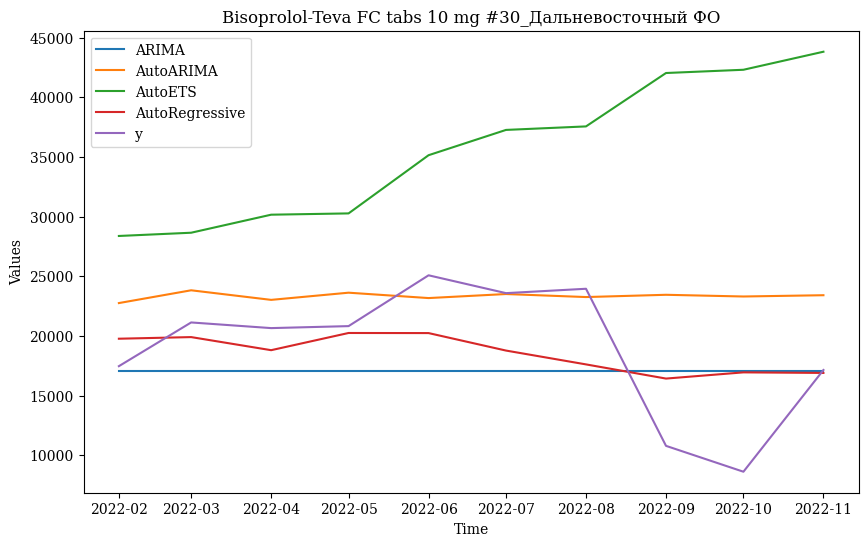

In [46]:
plt.figure(figsize=(10, 6))

# first_product_preds = compare_preds[compare_preds['unique_id'] == 'Bisoprolol-Teva FC tabs 10 mg #30_Дальневосточный ФО']

for column in ['ARIMA', 'AutoARIMA', 'AutoETS', 'AutoRegressive', 'y']:
    plt.plot(first_product_preds[column], label=column)


plt.xlabel('Time')
plt.ylabel('Values')
plt.title('Bisoprolol-Teva FC tabs 10 mg #30_Дальневосточный ФО')
plt.legend()
plt.show()

<font color='gold'>AutoRegressive seems like the best model. Let's use that</font>

In [37]:
evaluation_ETS = evaluation[['level','metric']+[c for c in evaluation.columns if "ETS" in c]]
evaluation_ETS

,level,metric,AutoETS,AutoETS/BottomUp,AutoETS/TopDown_method-forecast_proportions,AutoETS/MinTrace_method-wls_struct,AutoETS/OptimalCombination_method-wls_struct
0,Overall,MedAPE,78.34,77.61,132.96,223.30,223.30
1,Overall,mape,781.17,783.96,879.34,25308.28,25308.28
2,Overall,smape,883.88,890.43,1046.90,1109.31,1109.31
3,Molecule,MedAPE,5.97,33.23,5.97,25.84,25.84
4,Molecule,mape,17.69,32.27,17.69,24.84,24.84
5,Molecule,smape,151.73,396.72,151.73,286.99,286.99
6,Molecule/Product,MedAPE,49.39,48.78,89.46,90.35,90.35
7,Molecule/Product,mape,55.54,77.71,135.00,867.37,867.37
8,Molecule/Product,smape,564.52,563.91,779.02,866.50,866.50
9,Molecule/Product/Region,MedAPE,85.24,85.24,150.15,297.78,297.78


In [38]:
evaluation_AutoRegressive = evaluation[['level','metric']+[c for c in evaluation.columns if "AutoRegressive" in c]]
evaluation_AutoRegressive

,level,metric,AutoRegressive,AutoRegressive/BottomUp,AutoRegressive/TopDown_method-forecast_proportions,AutoRegressive/MinTrace_method-wls_struct,AutoRegressive/OptimalCombination_method-wls_struct
0,Overall,MedAPE,55.84,59.51,149.28,198.61,198.61
1,Overall,mape,829.39,830.33,1734.82,30873.04,30873.04
2,Overall,smape,745.86,763.04,976.56,1094.16,1094.16
3,Molecule,MedAPE,10.59,55.07,10.59,32.55,32.55
4,Molecule,mape,15.56,55.14,15.56,35.25,35.25
5,Molecule,smape,162.56,771.07,162.56,442.35,442.35
6,Molecule/Product,MedAPE,34.16,36.61,111.77,51.32,51.32
7,Molecule/Product,mape,64.72,63.53,169.95,1008.42,1008.42
8,Molecule/Product,smape,494.95,501.73,740.97,817.41,817.41
9,Molecule/Product/Region,MedAPE,71.74,71.74,179.54,303.91,303.91


In [39]:
evaluation_SeasESOpt = evaluation[['level','metric']+[c for c in evaluation.columns if "SeasESOpt" in c]]
evaluation_SeasESOpt

,level,metric,SeasESOpt,SeasESOpt/BottomUp,SeasESOpt/TopDown_method-forecast_proportions,SeasESOpt/MinTrace_method-wls_struct,SeasESOpt/OptimalCombination_method-wls_struct
0,Overall,MedAPE,59.17,59.37,121.67,203.13,203.13
1,Overall,mape,397.62,397.14,843.94,33719.81,33719.81
2,Overall,smape,736.94,744.05,916.68,1086.61,1086.61
3,Molecule,MedAPE,26.65,51.72,26.65,32.35,32.35
4,Molecule,mape,25.01,51.35,25.01,32.41,32.41
5,Molecule,smape,267.29,706.96,267.29,420.89,420.89
6,Molecule/Product,MedAPE,41.30,29.34,76.48,58.96,58.96
7,Molecule/Product,mape,65.87,54.87,148.87,1096.37,1096.37
8,Molecule/Product,smape,551.61,507.40,673.43,802.41,802.41
9,Molecule/Product/Region,MedAPE,66.57,66.57,135.08,286.72,286.72


In [40]:
evaluation_AutoETS = evaluation[['level','metric']+[c for c in evaluation.columns if "AutoETS" in c]]
evaluation_AutoETS

,level,metric,AutoETS,AutoETS/BottomUp,AutoETS/TopDown_method-forecast_proportions,AutoETS/MinTrace_method-wls_struct,AutoETS/OptimalCombination_method-wls_struct
0,Overall,MedAPE,78.34,77.61,132.96,223.30,223.30
1,Overall,mape,781.17,783.96,879.34,25308.28,25308.28
2,Overall,smape,883.88,890.43,1046.90,1109.31,1109.31
3,Molecule,MedAPE,5.97,33.23,5.97,25.84,25.84
4,Molecule,mape,17.69,32.27,17.69,24.84,24.84
5,Molecule,smape,151.73,396.72,151.73,286.99,286.99
6,Molecule/Product,MedAPE,49.39,48.78,89.46,90.35,90.35
7,Molecule/Product,mape,55.54,77.71,135.00,867.37,867.37
8,Molecule/Product,smape,564.52,563.91,779.02,866.50,866.50
9,Molecule/Product/Region,MedAPE,85.24,85.24,150.15,297.78,297.78


Observe that the nonnegative reconciliation method performs better that its unconstrained counterpart.

## Plot Hierarchy & Evaluations

In [41]:
'''The months are incorrect  for b!!!'''

'The months are incorrect  for b!!!'

In [42]:
#temp = Y_rec_df.loc[Y_test_df.index]
merged_test_preds_df = Y_test_df.merge(Y_rec_df, on=['unique_id', 'ds'], how='inner')
merged_test_preds_df

,ds,y,Naive,AutoETS,ARIMA,AutoARIMA,SeasESOpt,AutoRegressive,RWD,Naive/BottomUp,...,SeasESOpt/MinTrace_method-wls_struct,AutoRegressive/MinTrace_method-wls_struct,RWD/MinTrace_method-wls_struct,Naive/OptimalCombination_method-wls_struct,AutoETS/OptimalCombination_method-wls_struct,ARIMA/OptimalCombination_method-wls_struct,AutoARIMA/OptimalCombination_method-wls_struct,SeasESOpt/OptimalCombination_method-wls_struct,AutoRegressive/OptimalCombination_method-wls_struct,RWD/OptimalCombination_method-wls_struct
unique_id,,,,,,,,,,,,,,,,,,,,,
Bisoprolol-Teva FC tabs 10 mg #30_Дальневосточный ФО,2022-02-01,17466,24183.0,2.837745e+04,1.705826e+04,2.275467e+04,1.952494e+04,1.976712e+04,2.461144e+04,24183.0,...,3.580733e+04,3.157920e+04,4.585420e+04,4.505383e+04,5.145267e+04,3.377458e+04,5.267739e+04,3.580733e+04,3.157920e+04,4.585420e+04
Bisoprolol-Teva FC tabs 10 mg #30_Дальневосточный ФО,2022-03-01,21130,24183.0,2.864923e+04,1.705826e+04,2.382534e+04,6.069652e+03,1.990385e+04,2.503987e+04,24183.0,...,2.525943e+04,3.797202e+04,4.665458e+04,4.505383e+04,4.457738e+04,3.377458e+04,5.505895e+04,2.525943e+04,3.797202e+04,4.665458e+04
Bisoprolol-Teva FC tabs 10 mg #30_Дальневосточный ФО,2022-04-01,20656,24183.0,3.016079e+04,1.705826e+04,2.302277e+04,2.127306e+04,1.880614e+04,2.546830e+04,24183.0,...,4.502285e+04,3.731694e+04,4.745495e+04,4.505383e+04,4.593041e+04,3.377458e+04,5.266937e+04,4.502285e+04,3.731694e+04,4.745495e+04
Bisoprolol-Teva FC tabs 10 mg #30_Дальневосточный ФО,2022-05-01,20823,24183.0,3.026848e+04,1.705826e+04,2.362438e+04,1.812142e+04,2.024722e+04,2.589674e+04,24183.0,...,4.103902e+04,4.535281e+04,4.825532e+04,4.505383e+04,4.691685e+04,3.377458e+04,5.225525e+04,4.103902e+04,4.535281e+04,4.825532e+04
Bisoprolol-Teva FC tabs 10 mg #30_Дальневосточный ФО,2022-06-01,25081,24183.0,3.514553e+04,1.705826e+04,2.317341e+04,1.736231e+04,2.023973e+04,2.632517e+04,24183.0,...,3.605333e+04,3.886447e+04,4.905569e+04,4.505383e+04,5.227795e+04,3.377458e+04,5.385942e+04,3.605333e+04,3.886447e+04,4.905569e+04
Bisoprolol-Teva FC tabs 10 mg #30_Дальневосточный ФО,2022-07-01,23586,24183.0,3.726450e+04,1.705826e+04,2.351146e+04,2.051509e+04,1.877402e+04,2.675361e+04,24183.0,...,2.662370e+04,3.559124e+04,4.985606e+04,4.505383e+04,5.529120e+04,3.377458e+04,5.662900e+04,2.662370e+04,3.559124e+04,4.985606e+04
Bisoprolol-Teva FC tabs 10 mg #30_Дальневосточный ФО,2022-08-01,23953,24183.0,3.755830e+04,1.705826e+04,2.325806e+04,1.568351e+04,1.761550e+04,2.718204e+04,24183.0,...,1.013736e+04,3.055051e+04,5.065643e+04,4.505383e+04,5.678425e+04,3.377458e+04,5.934777e+04,1.013736e+04,3.055051e+04,5.065643e+04
Bisoprolol-Teva FC tabs 10 mg #30_Дальневосточный ФО,2022-09-01,10789,24183.0,4.203395e+04,1.705826e+04,2.344800e+04,1.952494e+04,1.642786e+04,2.761048e+04,24183.0,...,3.580733e+04,3.413108e+04,5.145681e+04,4.505383e+04,6.207460e+04,3.377458e+04,6.039709e+04,3.580733e+04,3.413108e+04,5.145681e+04
Bisoprolol-Teva FC tabs 10 mg #30_Дальневосточный ФО,2022-10-01,8621,24183.0,4.230573e+04,1.705826e+04,2.330562e+04,6.069652e+03,1.694795e+04,2.803891e+04,24183.0,...,2.525943e+04,3.751952e+04,5.225718e+04,4.505383e+04,5.520438e+04,3.377458e+04,6.040409e+04,2.525943e+04,3.751952e+04,5.225718e+04


In [43]:
merged_test_preds_df = merged_test_preds_df.sort_values(by='ds', ascending=True)
# merged_test_preds_df.set_index('unique_id', inplace=True)

merged_test_preds_df

,ds,y,Naive,AutoETS,ARIMA,AutoARIMA,SeasESOpt,AutoRegressive,RWD,Naive/BottomUp,...,SeasESOpt/MinTrace_method-wls_struct,AutoRegressive/MinTrace_method-wls_struct,RWD/MinTrace_method-wls_struct,Naive/OptimalCombination_method-wls_struct,AutoETS/OptimalCombination_method-wls_struct,ARIMA/OptimalCombination_method-wls_struct,AutoARIMA/OptimalCombination_method-wls_struct,SeasESOpt/OptimalCombination_method-wls_struct,AutoRegressive/OptimalCombination_method-wls_struct,RWD/OptimalCombination_method-wls_struct
unique_id,,,,,,,,,,,,,,,,,,,,,
Bisoprolol-Teva FC tabs 10 mg #30_Дальневосточный ФО,2022-02-01,17466,24183.0,2.837745e+04,1.705826e+04,2.275467e+04,1.952494e+04,1.976712e+04,2.461144e+04,24183.0,...,3.580733e+04,3.157920e+04,4.585420e+04,4.505383e+04,5.145267e+04,3.377458e+04,5.267739e+04,3.580733e+04,3.157920e+04,4.585420e+04
Bisoprolol-Teva FC tabs 10 mg #30,2022-02-01,305182,469190.0,4.878302e+05,4.674462e+05,4.691900e+05,3.494135e+05,3.978005e+05,4.762054e+05,469190.0,...,4.914172e+05,5.364716e+05,6.461476e+05,6.361567e+05,6.059558e+05,6.011768e+05,6.331779e+05,4.914172e+05,5.364716e+05,6.461476e+05
Bisoprolol-Teva FC tabs 5 mg #50_Южный ФО,2022-02-01,1653,1975.0,1.141535e+03,2.277426e+03,1.609561e+03,2.051048e+03,1.304233e+03,2.016435e+03,1975.0,...,1.899222e+04,1.626125e+04,2.325920e+04,2.284583e+04,1.999379e+04,1.899375e+04,2.694803e+04,1.899222e+04,1.626125e+04,2.325920e+04
Bisoprolol-Teva FC tabs 10 mg #50_Приволжский ФО,2022-02-01,1600,1588.0,5.002509e+02,9.856170e+02,1.429311e+03,9.816812e+02,1.567741e+03,1.601152e+03,1588.0,...,1.797536e+04,1.616965e+04,2.284392e+04,2.245883e+04,1.933729e+04,1.770194e+04,2.660877e+04,1.797536e+04,1.616965e+04,2.284392e+04
Bisoprolol-Teva FC tabs 5 mg #30_Южный ФО,2022-02-01,130143,173883.0,1.474953e+05,1.178247e+05,1.712999e+05,2.253936e+05,1.768830e+05,1.774157e+05,173883.0,...,2.537842e+05,1.940146e+05,1.986585e+05,1.947538e+05,1.653776e+05,1.345410e+05,1.824547e+05,2.537842e+05,1.940146e+05,1.986585e+05
Bisoprolol-Teva FC tabs 5 mg #30_Приволжский ФО,2022-02-01,30969,112252.0,1.736781e+05,1.843681e+05,1.122520e+05,2.213724e+05,7.274149e+04,1.130623e+05,112252.0,...,2.497630e+05,8.987314e+04,1.343050e+05,1.331228e+05,1.915604e+05,2.010844e+05,1.234067e+05,2.497630e+05,8.987314e+04,1.343050e+05
Bisoprolol-Teva FC tabs 10 mg #50_Южный ФО,2022-02-01,1371,1357.0,1.323037e+03,1.081596e+03,1.089433e+03,5.514325e+02,2.009749e+03,1.382565e+03,1357.0,...,1.754511e+04,1.661166e+04,2.262533e+04,2.222783e+04,2.016008e+04,1.779792e+04,2.626889e+04,1.754511e+04,1.661166e+04,2.262533e+04
Bisoprolol-Teva FC tabs 5 mg #50_Приволжский ФО,2022-02-01,658,1943.0,4.715136e+03,3.928596e+03,1.385689e+03,1.932245e+03,2.021914e+03,1.962065e+03,1943.0,...,1.887342e+04,1.697894e+04,2.320483e+04,2.281383e+04,2.356739e+04,2.064492e+04,2.672416e+04,1.887342e+04,1.697894e+04,2.320483e+04
Bisoprolol-Teva FC tabs 10 mg #30_Южный ФО,2022-02-01,47680,50608.0,3.490125e+04,2.805511e+04,4.629868e+04,2.151378e+04,4.052521e+04,5.148487e+04,50608.0,...,3.779617e+04,5.233728e+04,7.272764e+04,7.147883e+04,5.797648e+04,4.477143e+04,7.622140e+04,3.779617e+04,5.233728e+04,7.272764e+04


KeyError: 'ETS'

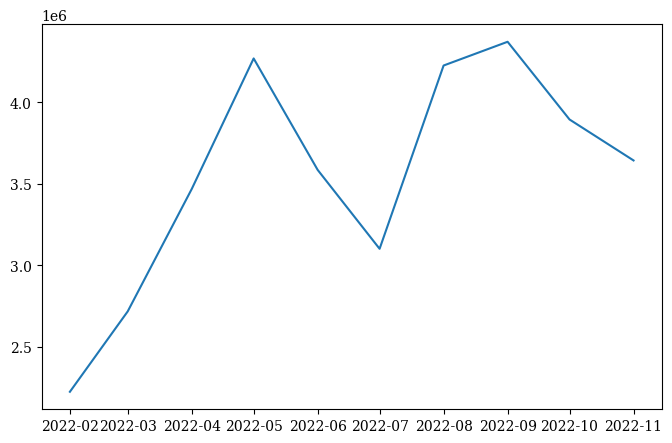

In [44]:
hplt = HierarchicalPlot(S=S_df, tags=tags)

hplt.plot_hierarchical_predictions_gap(Y_df=merged_test_preds_df, models = 'ETS')#['ETS', 'Naive', 'ETS/BottomUp', 'Naive/BottomUp'])

In [ ]:
hplt.plot_hierarchically_linked_series(bottom_series='Северо-западный ФО_Bisoprolol-Teva FC tabs 5 mg #50', Y_df=Y_train_df)

Exception: bottom time series Северо-западный ФО_Bisoprolol-Teva FC tabs 5 mg #50 not found

In [ ]:
# pd.read_csv('https://raw.githubusercontent.com/Nixtla/transfer-learning-time-series/main/datasets/tourism.csv')

In [ ]:
# Y_df = pd.read_csv('https://raw.githubusercontent.com/Nixtla/transfer-learning-time-series/main/datasets/tourism.csv')
# Y_df = Y_df.rename({'Trips': 'y', 'Quarter': 'ds'}, axis=1)
# Y_df.insert(0, 'Country', 'Australia')
# Y_df = Y_df[['Country', 'Region', 'State', 'Purpose', 'ds', 'y']]
# Y_df['ds'] = Y_df['ds'].str.replace(r'(\d+) (Q\d)', r'\1-\2', regex=True)
# Y_df['ds'] = pd.to_datetime(Y_df['ds'])
# Y_df.head()